In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [73]:
df = pd.read_csv("diabetes.csv")

In [74]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


#Splitting Dataset

In [75]:
train, valid, test = np.split(df.sample(frac=1, random_state=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [76]:
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
for col in cols:
    df[col] = df[col].replace(0, df[col].mean())

# Scaling, balancing & returning dataset


In [77]:
def scale_dataset(dataframe, scaler, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  if scaler is None:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
  else:
    X = scaler.transform(X)

  if oversample:
    sm = SMOTE(random_state=1)
    X, y = sm.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y, scaler

In [78]:
train, X_train, y_train, scaler = scale_dataset(train, None, oversample=True)
valid, X_val, y_val, scaler = scale_dataset(valid, scaler, oversample=False)
test, X_test, y_test, scaler = scale_dataset(test, scaler, oversample=False)

# Implementing Random Search for K-Nearest Neighbors

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

knn_param_dist = {
    'n_neighbors': np.arange(1, 100),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_random_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=knn_param_dist,
    n_iter=50,
    cv=5,       # K Fold Cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

knn_random_search.fit(X_train, y_train)

print("Best parameters for KNN:", knn_random_search.best_params_)
print("Best cross-validation accuracy for KNN:", knn_random_search.best_score_)

best_knn_model = knn_random_search.best_estimator_

y_pred_knn_tuned = best_knn_model.predict(X_test)

print("\nClassification Report for Tuned KNN:")
print(classification_report(y_test, y_pred_knn_tuned))

Best parameters for KNN: {'weights': 'distance', 'n_neighbors': np.int64(5), 'metric': 'euclidean'}
Best cross-validation accuracy for KNN: 0.8389355742296919

Classification Report for Tuned KNN:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        97
           1       0.62      0.72      0.67        57

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



#K-Nearest Neighbours (kNN)

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [81]:
knn_model = KNeighborsClassifier(n_neighbors=70)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=70)

In [82]:
y_pred_knn = knn_model.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79        97
           1       0.65      0.70      0.67        57

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.75      0.75      0.75       154



#Naive Bayes

In [84]:
from sklearn.naive_bayes import GaussianNB

In [85]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [86]:
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80        97
           1       0.65      0.68      0.67        57

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



# Implementing Random Search for Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import uniform

lg_param_dist = [
    {
        'C': uniform(loc=0, scale=4),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    {
        'C': uniform(loc=0, scale=4),
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['saga'],
        'l1_ratio': uniform(loc=0, scale=1)
    },
    {
        'C': uniform(loc=0, scale=4),
        'penalty': ['l2', None],
        'solver': ['newton-cg', 'lbfgs', 'sag']
    }
]

lg_estimator = LogisticRegression(max_iter=1000, random_state=42)

lg_random_search = RandomizedSearchCV(
    estimator=lg_estimator,
    param_distributions=lg_param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

lg_random_search.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", lg_random_search.best_params_)
print("Best cross-validation accuracy for Logistic Regression:", lg_random_search.best_score_)

best_lg_model = lg_random_search.best_estimator_

y_pred_lg_tuned = best_lg_model.predict(X_test)

print("\nClassification Report for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_lg_tuned))

Best parameters for Logistic Regression: {'C': np.float64(0.26020637194111806), 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 0.761750700280112

Classification Report for Tuned Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78        97
           1       0.62      0.68      0.65        57

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.73      0.73      0.73       154



#Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [90]:
y_pred_lg = lg_model.predict(X_test)
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79        97
           1       0.64      0.68      0.66        57

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.74      0.74      0.74       154



#Support Vector Machine (SVM)

In [91]:
from sklearn.svm import SVC

In [92]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [93]:
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80        97
           1       0.65      0.72      0.68        57

    accuracy                           0.75       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.76      0.75      0.76       154



#Multiple Linear Regression

In [94]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [95]:
y_pred_linr = lin_reg.predict(X_test)
y_pred_linr = (y_pred_linr > 0.5).astype(int)

mae = mean_absolute_error(y_test, y_pred_linr)
mse = mean_squared_error(y_test, y_pred_linr)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.27
Mean Squared Error (MSE): 0.27
Root Mean Squared Error (RMSE): 0.52


In [96]:
accuracy_linr = accuracy_score(y_test, y_pred_linr)
print("Accuracy:", accuracy_linr)
print("F1:", f1_score(y_test, y_pred_linr)) #F1 checks how well the model handles false negatives/positives.
print("AUC:", roc_auc_score(y_test, y_pred_linr)) #AUC measures how well the model seperates diabetics vs. non-diabetics across possible thresholds.

Accuracy: 0.7337662337662337
F1: 0.6554621848739496
AUC: 0.7235485621269668


#Random Forest Regression

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
rf_reg = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42)
rf_reg.fit(X_train, y_train.flatten())

RandomForestRegressor(max_depth=10, n_estimators=250, random_state=42)

In [99]:
y_pred_rf = rf_reg.predict(X_test)
y_pred_rf = (y_pred_rf > 0.5).astype(int)

mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.28
Mean Squared Error (MSE): 0.28
Root Mean Squared Error (RMSE): 0.53


In [100]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        97
           1       0.62      0.61      0.62        57

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



In [101]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Accuracy:", accuracy_rf)
print("F1:", f1_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_pred_rf))

Accuracy: 0.7207792207792207
F1: 0.6194690265486725
AUC: 0.6987701211792369


# XGBoost

In [102]:
from xgboost import XGBClassifier

In [103]:
xgboost = XGBClassifier(
    n_estimators=300,       # number of trees
    learning_rate=0.05,     # step size shrinkage
    max_depth=6,            # tree depth
    subsample=0.8,          # % of rows per tree
    colsample_bytree=0.8,   # % of features per tree
    gamma=0,                # minimum loss reduction for a split
    reg_lambda=1,           # L2 regularization
    reg_alpha=0,            # L1 regularization
    random_state=42,
    n_jobs=-1
)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [104]:
y_pred_xgb = xgboost.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.26
Mean Squared Error (MSE): 0.26
Root Mean Squared Error (RMSE): 0.51


In [105]:
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1:", f1_score(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_pred_xgb))

Accuracy: 0.7402597402597403
F1: 0.6551724137931034
AUC: 0.7250859106529208


#Model Accuracy Graph

/tmp/ipython-input-539424639.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')


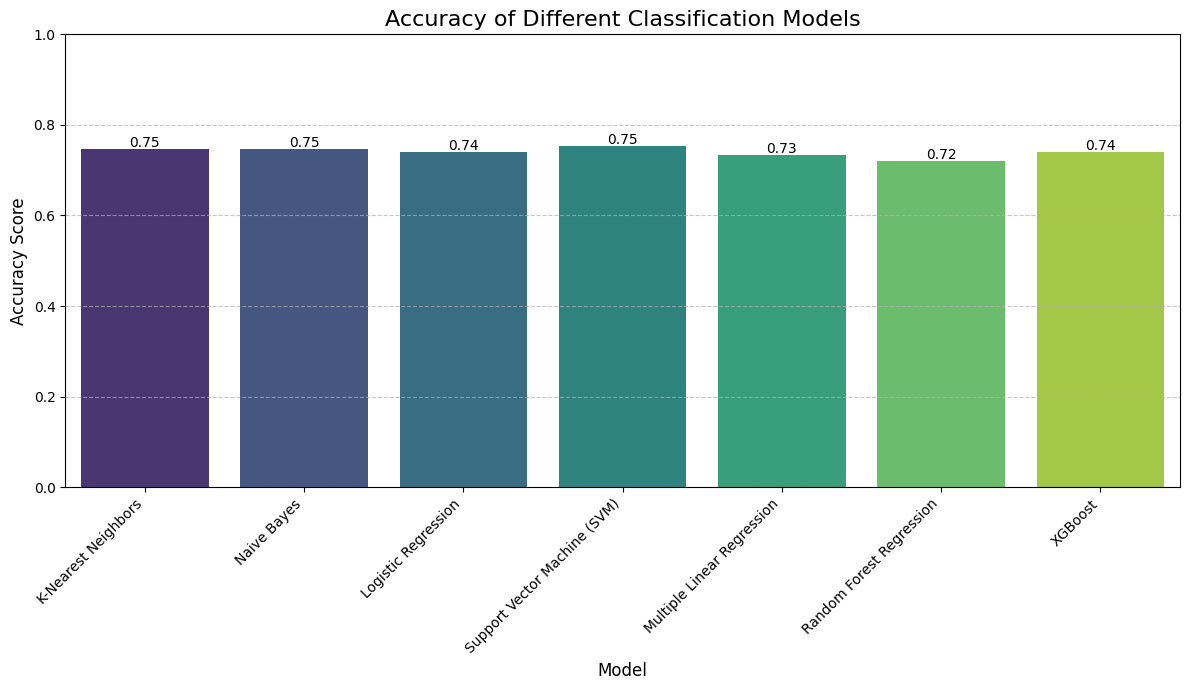

In [106]:
model_accuracies = {
    "K-Nearest Neighbors": accuracy_score(y_test, y_pred_knn),
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "Logistic Regression": accuracy_score(y_test, y_pred_lg),
    "Support Vector Machine (SVM)": accuracy_score(y_test, y_pred_svm),
    "Multiple Linear Regression": accuracy_score(y_test, y_pred_linr),
    "Random Forest Regression": accuracy_score(y_test, y_pred_rf),
    "XGBoost": accuracy_score(y_test, y_pred_xgb),
}

accuracy_df = pd.DataFrame(
    list(model_accuracies.items()),
    columns=['Model', 'Accuracy']
)

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')
plt.ylim(0, 1)
plt.title('Accuracy of Different Classification Models', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xticks(rotation=45, ha='right')

for index, row in accuracy_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.005, f'{row['Accuracy']:.2f}', color='black', ha="center")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()